In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
random_seed = 76

## Sample Data

In [3]:
df = pd.read_csv("datasets/FIFA 2018 Statistics.csv")

In [4]:
df.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


## Data Preparation

In [5]:
numerical_features = [column for column in df.columns if df[column].dtype in [np.int64]]
X = df[numerical_features]
y = df['Man of the Match'].astype('category').cat.codes  # Convert `Yes` to 1 and `No` to 0 label

## Classification Model Construction

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

random_seed = 76

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_seed)
classifier = RandomForestClassifier(n_estimators=50, random_state=random_seed)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=76)

## Permutation Importance

In [7]:
import eli5
from eli5.sklearn import PermutationImportance

permutation = PermutationImportance(classifier, random_state=random_seed).fit(X_test, y_test)
eli5.show_weights(permutation, feature_names=X_test.columns.tolist())

Weight,Feature
0.0750 ± 0.0776,Goal Scored
0.0344 ± 0.0234,Blocked
0.0187 ± 0.0125,Pass Accuracy %
0.0156 ± 0.0198,Saves
0.0125 ± 0.0364,Ball Possession %
0.0031 ± 0.0306,Corners
0 ± 0.0000,Red
0 ± 0.0000,Goals in PSO
0 ± 0.0000,Yellow & Red
-0.0031 ± 0.0125,Offsides


## Partial Dependence Plots

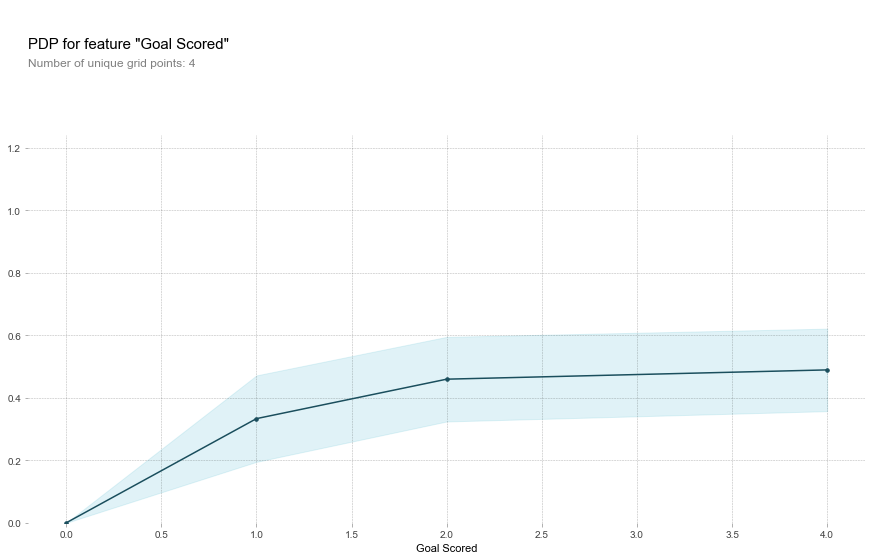

In [8]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


feature_name = 'Goal Scored'
pdp_goal_scores = pdp.pdp_isolate(model=classifier, dataset=X_test, model_features=numerical_features, feature=feature_name)

pdp.pdp_plot(pdp_goal_scores, feature_name)
plt.show()

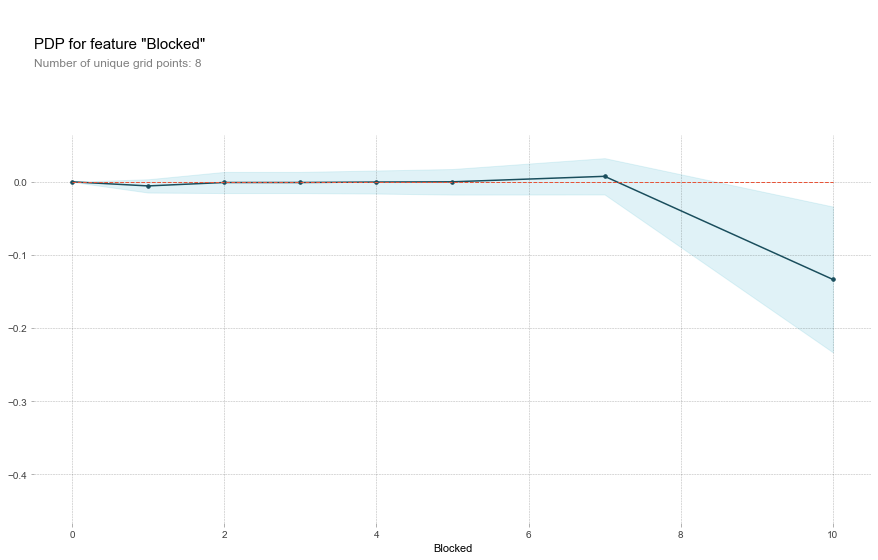

In [9]:
feature_name = 'Blocked'
pdp_goal_scores = pdp.pdp_isolate(model=classifier, dataset=X_test, model_features=numerical_features, feature=feature_name)

pdp.pdp_plot(pdp_goal_scores, feature_name)
plt.show()

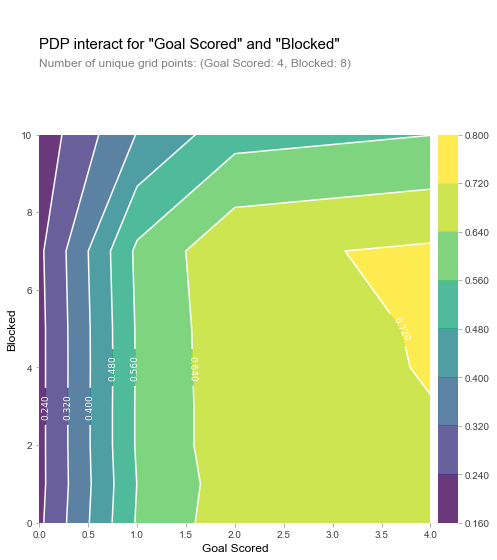

In [10]:
feature_names = ['Goal Scored', 'Blocked']
interact  =  pdp.pdp_interact(model=classifier, dataset=X_test, model_features=numerical_features, features=feature_names)

pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feature_names, plot_type='contour')
plt.show()

## SHAP Values

In [11]:
sample = X_test.iloc[0] # select first row of the test set
sample_array = np.expand_dims(sample.values, axis=0)

confidence = classifier.predict_proba(sample_array)
predicted_class = classifier.classes_[confidence.argmax()]
predicted_prob = confidence.max()

# class 1 is equal to "Win Man of the Match"
print(f"predicted class: {predicted_class} with confidence level: {predicted_prob}")

predicted class: 1 with confidence level: 0.84


In [12]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(sample)

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], sample)

## Summary Plots

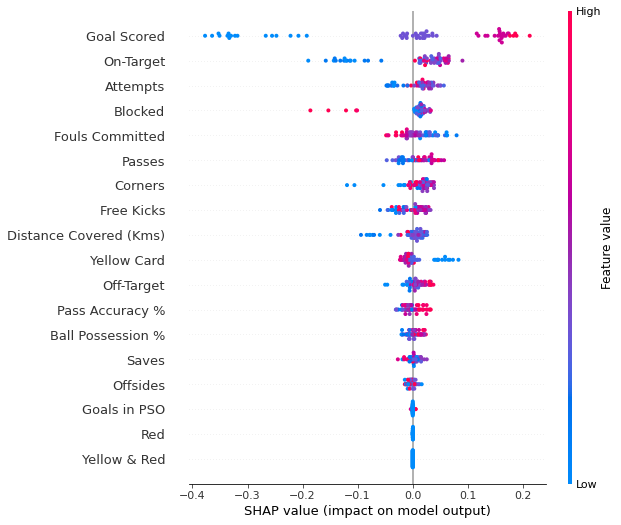

In [14]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)